In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import scipy
import time
import gget
from sklearn.decomposition import PCA
from kneed import KneeLocator
from importlib import reload

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.patheffects as pe

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # and to omit tensorflow logging

""" Increase scanpy output"""
sc.settings.verbosity = 3

# local 
import utils as ut
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/MC3R/notebooks/utils.py'>

In [2]:
fullpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/processed_data/all_subclustered.h5ad"
raw = sc.read(fullpath)

pdf = raw.copy()
pdf

AnnData object with n_obs × n_vars = 33647 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes', 'color', 'leiden', 'cluster_num', 'Cluster', 'cluster_cat', 'U1', 'U2', 'cell_type', 'neuron_clusters', 'neuron_cluster_num', 'neuron_cluster_name', 'neuron_cluster_cat', 'NU1', 'NU2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cluster', 'Cluster_colors', 'batch_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'neuron_clusters_colors', 'neuron_clusters_sizes', 'neuron_neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'neuron_neighbors_connectivities', 'neuron_neighbors_distances'

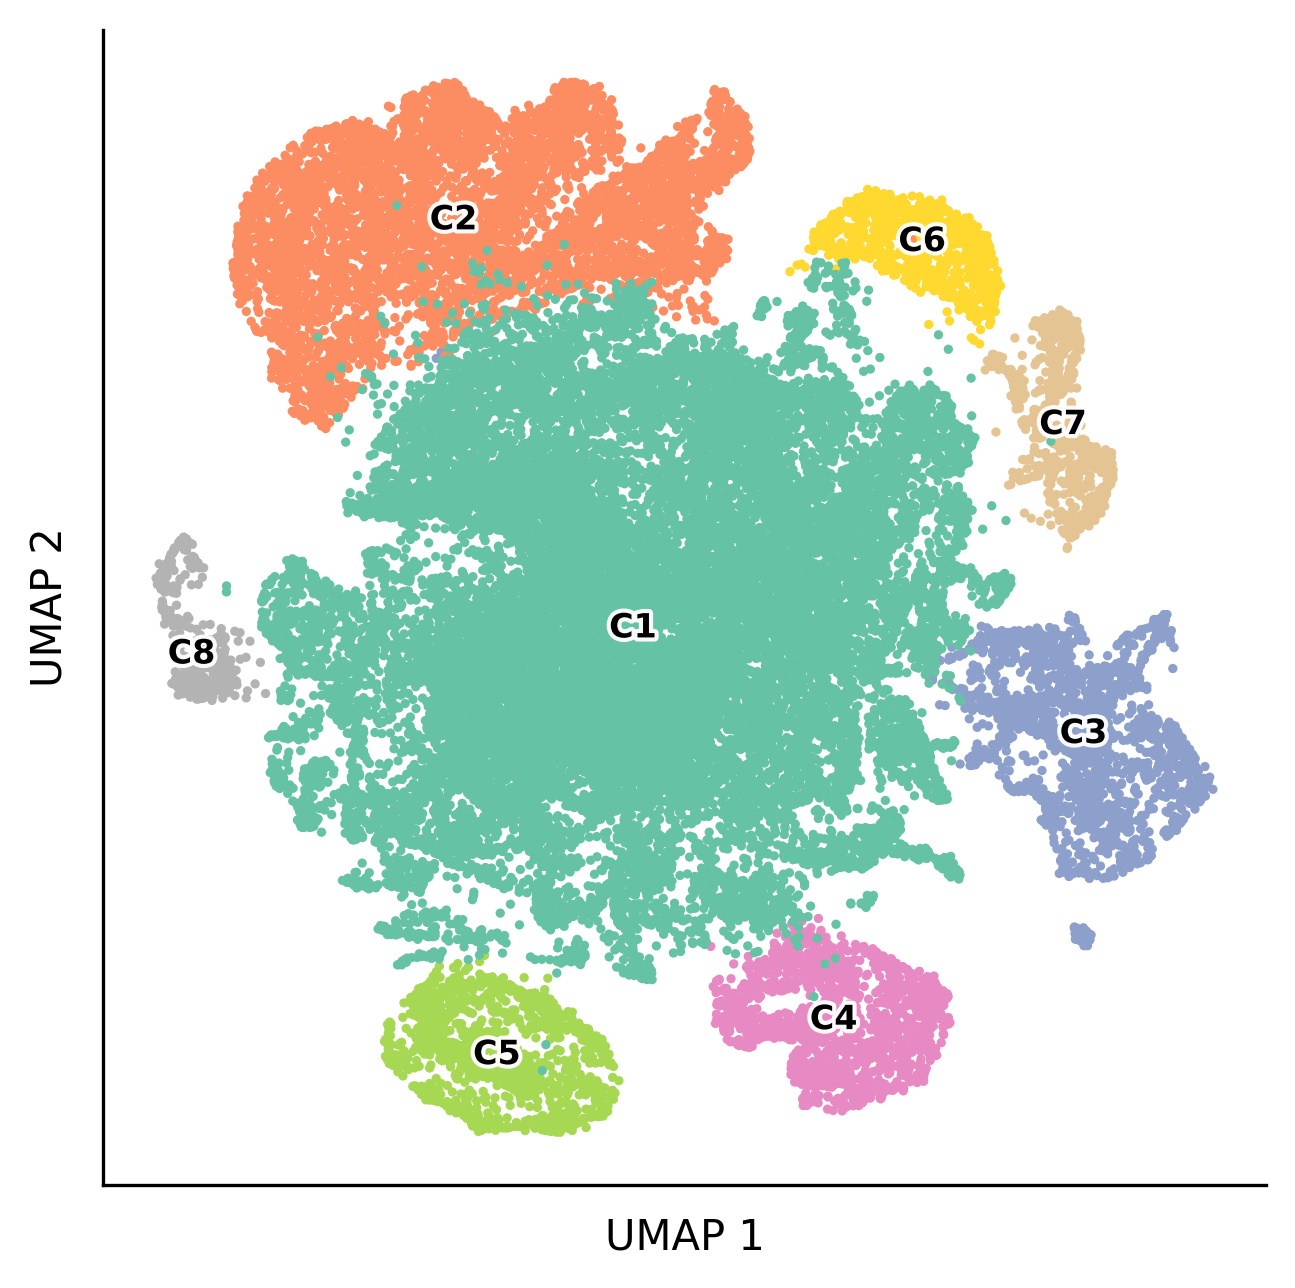

In [3]:
color_map = "Set2"

""" UMAP PLOT """
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

# sort the data frame
pdx = pdf.obs.copy()
pdx = pdx.sort_values(by='cell_type')
pdx = pdx.reset_index()

hue_order = sorted(pdx['neuron_cluster_name'].unique())
order = np.argsort(pdx['neuron_cluster_name'])[::-1]

sns.scatterplot(data=pdx.iloc[order],
                x='NU1',
                y='NU2',
                hue='neuron_cluster_name',
                hue_order=hue_order,
                palette=color_map,
                s=5,
                alpha=1.0,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# label on data
ax = plt.gca()

all_pos = (
        pdx.groupby('neuron_cluster_name')[['NU1', 'NU2']]
        .median()
        .sort_index()
    )

for label, x_pos, y_pos in all_pos.itertuples():
    ax.text(
        x_pos,
        y_pos,
        label,
        weight='bold',
        path_effects=[pe.withStroke(linewidth=2, foreground="w", alpha=0.95,)],
        verticalalignment="center",
        horizontalalignment="center",
        fontsize='8',
    )

plt.gca().legend().remove()


# outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/analysis_files/figures/neuron_cluster_umap.png"
# plt.savefig(outpath)
# print(f"saved: {outpath}")

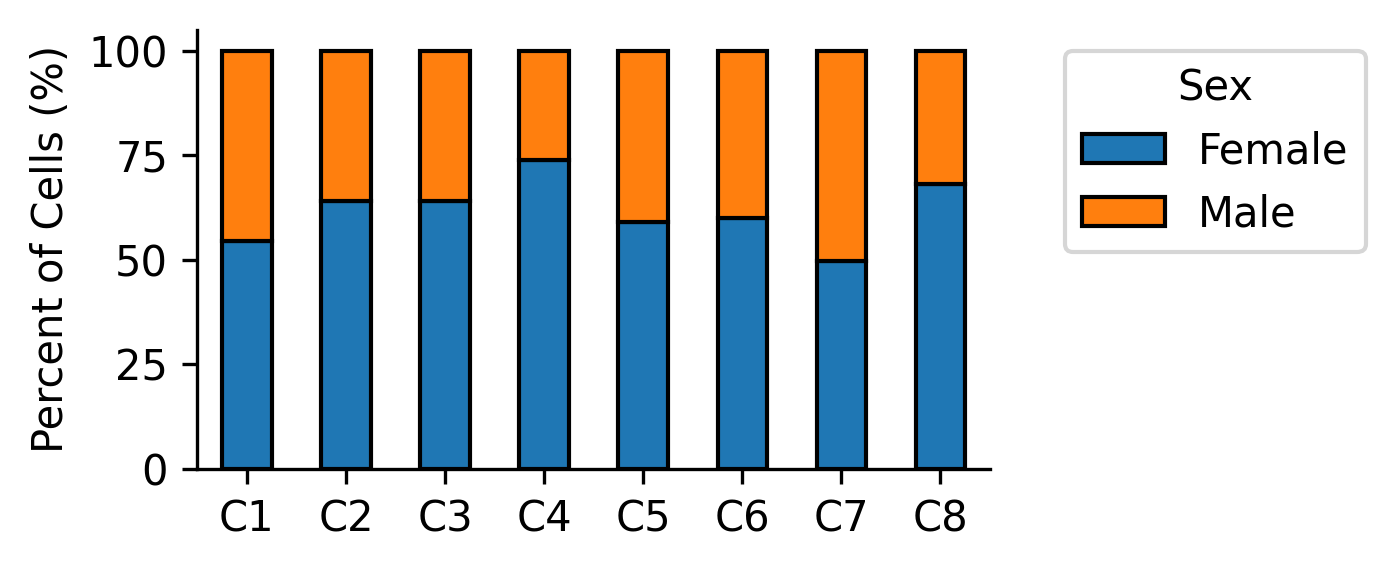

In [4]:
def plot_clusters_by_column_pct(df, column_name):
    """
    Plots the percentage of rows of each neuron_cluster_name across all values of a given column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to group by.
    """

    # Group data, then calculate overall percentage of each cluster
    clusters_total = df.groupby('neuron_cluster_name')['neuron_cluster_name'].size()
    clusters_per_group = df.groupby([column_name, 'neuron_cluster_name'])['neuron_cluster_name'].size()
    clusters_per_group = (100 * clusters_per_group / clusters_total).unstack(fill_value=0).transpose()

    # Create a stacked bar plot
    clusters_per_group.plot(kind='bar', stacked=True, ec='k')

    # Labels and title
    plt.ylabel('Percent of Cells (%)')
    plt.xlabel("")
    
    # Ensure labels are readable 
    plt.xticks(rotation=0)
    plt.tight_layout()
    sns.move_legend(plt.gca(), 
                    loc='upper right',
                    bbox_to_anchor=(1.5, 1))
    sns.despine()
    plt.show()


pdx = pdf.obs.copy()
pdx['Sex'] = pdx['Sex'].map({
    'f' : 'Female',
    'm' : 'Male',
})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5.5, 2
plot_clusters_by_column_pct(pdx, 'Sex')

In [5]:
# break

# Fed state DEG (by Sex)

In [70]:
cdf = pdf.copy()
cdf = cdf[cdf.obs['Diet'] == 'fed']
sc.tl.rank_genes_groups(cdf, 
                        groupby='Sex',
                        method='wilcoxon',
                        key_added=key,
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(cdf, 
                                  group='f',
                                  key=key)

deg.head()

ranking genes
    finished: added to `.uns['C8_fed_by_sex']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:55)


,names,scores,logfoldchanges,pvals,pvals_adj
0,Xist,96.343849,13.851648,0.000000e+00,0.000000e+00
1,Tsix,57.992672,8.184645,0.000000e+00,0.000000e+00
2,AY036118,31.180635,1.093470,1.950291e-213,6.109287e-210
3,Oxt,27.488640,2.665898,2.400279e-166,6.683443e-163
4,Avp,26.523643,2.584536,5.173874e-155,1.178702e-151


/home/cstansbu/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


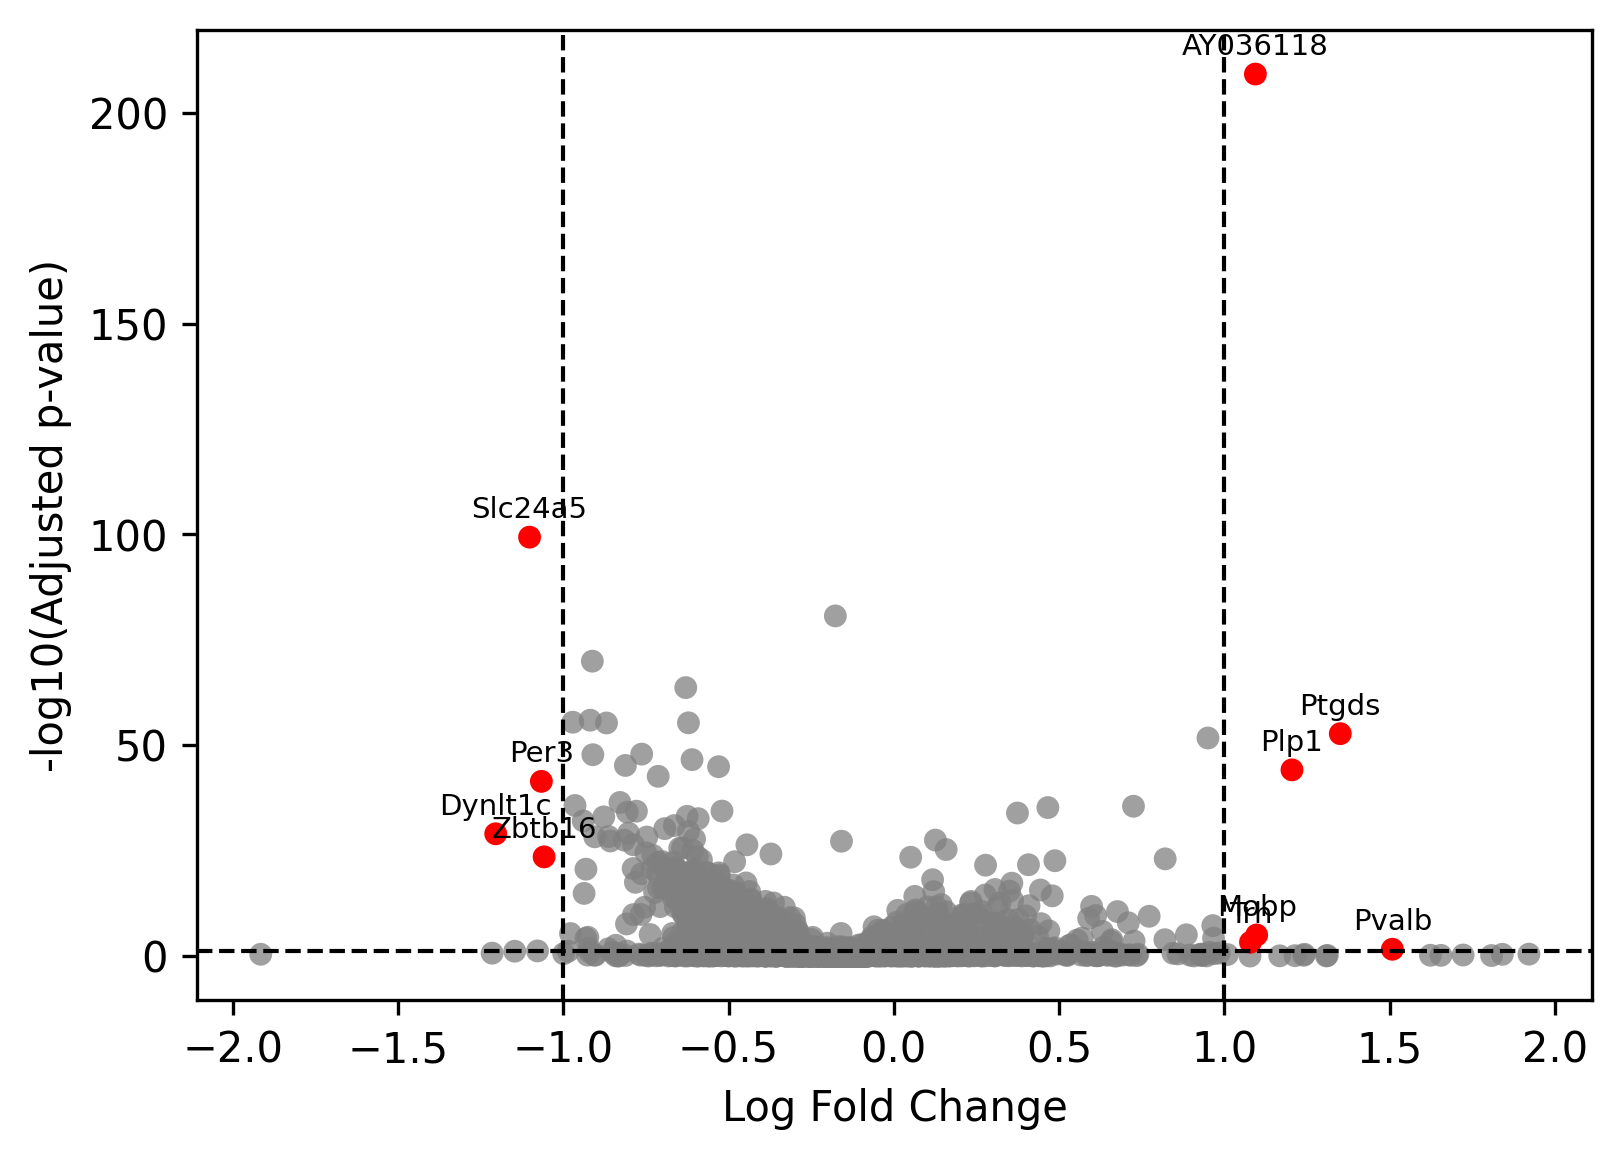

In [104]:
def create_volcano_plot(df, pval_threshold=0.05, logfc_threshold=1, 
                        min_logfc=None, max_logfc=None,
                        highlight_color='red'):
    """
    Creates an enhanced volcano plot with customizable visual parameters.

    Args:
        df (pandas.DataFrame): Input DataFrame containing gene expression data.
        pval_threshold (float): Log fold change threshold for significance (optional). 
                            Defaults to 0.05.
        logfc_threshold (float): Log fold change threshold for significance (optional). 
                             Defaults to 1.
        min_logfc (float): Minimum log fold change to display on the plot (optional).
        max_logfc (float): Maximum log fold change to display on the plot (optional).
        highlight_color (str): Color used for highlighting significant genes (optional). 
                               Defaults to 'red'.
    """                    
                            
    # filter out certain clases of genes
    df = df[(~df['names'].str.startswith("Gm")) &
            (~df['names'].str.startswith("mt")) &
            (~df['names'].str.endswith("Rik"))].reset_index(drop=True)
    
    # Calculate -log10(p-value)
    df['-log10(pval_adj)'] = -np.log10(df['pvals_adj']) 
    df = df[df['-log10(pval_adj)'] > 0]

    # Fold change thresholds
    if not min_logfc is None:
        df = df[df['logfoldchanges'] > min_logfc]
    if not max_logfc is None:
        df = df[df['logfoldchanges'] < max_logfc]

    # Filter significant genes 
    df_significant = df[
        (np.abs(df['logfoldchanges']) >= logfc_threshold) &
        (df['-log10(pval_adj)'] >= -np.log10(pval_threshold))
    ]
    df_not_significant = df[~df.index.isin(df_significant.index)]

    # Create the volcano plot (no figsize)
    plt.figure() 

    # Plot non-significant genes
    sns.scatterplot(data=df_not_significant, 
                    x='logfoldchanges', 
                    y='-log10(pval_adj)',
                    color='gray',
                    ec='none',
                    s=30,
                    alpha=0.75,
                    zorder=1,
                   ) 

    # Plot significant genes with highlighting
    sns.scatterplot(data=df_significant, 
                    x='logfoldchanges', 
                    y='-log10(pval_adj)',
                    color=highlight_color, 
                    ec='none',
                    s=30,
                    zorder=2,
                   )

    # Add labels for significant genes
    for i, row in df_significant.iterrows():
        plt.text(row['logfoldchanges'], 
                 row['-log10(pval_adj)'] + 4.5, 
                 row['names'], ha='center', 
                 fontsize=7)

    plt.xlabel('Log Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')

    # Add significance lines
    plt.axvline(x=-logfc_threshold, 
                color='k',
                linestyle='--', 
                linewidth=1)
                            
    plt.axvline(x=logfc_threshold, 
                color='k',
                linestyle='--',
                linewidth=1)
                            
    plt.axhline(y=-np.log10(pval_threshold), 
                color='k', 
                linestyle='--',
                linewidth=1)
                            
    plt.show()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4.2
create_volcano_plot(deg, 
                    logfc_threshold=1.0,
                    min_logfc=-2.5, 
                    max_logfc=2.5)

# Fed state DEG (By Sex + by cluster)

In [49]:
pdf.obs['Sex'].value_counts()

f    19453
m    14194
Name: Sex, dtype: int64

In [53]:
res = []

for cluster in sorted(pdf.obs['neuron_cluster_name'].unique()):
    
    cdf = pdf[pdf.obs['neuron_cluster_name'] == cluster].copy()
    cdf = cdf[cdf.obs['Diet'] == 'fed']
    
    key = f'{cluster}_fed_by_sex'

    sc.tl.rank_genes_groups(cdf, 
                            groupby='Sex',
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')

    deg = sc.get.rank_genes_groups_df(cdf, 
                                      group='f',
                                      key=key)
    
    deg['cluster'] = cluster
    res.append(deg)

res = pd.concat(res)
print(f"{res.shape=}")
res.head()

ranking genes
    finished: added to `.uns['C1_fed_by_sex']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:40)
ranking genes
    finished: added to `.uns['C2_fed_by_sex']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes
    finished: added to `.uns['C3_fed_by_sex']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by gr

,names,scores,logfoldchanges,pvals,pvals_adj,cluster
0,Xist,87.693542,14.748156,0.000000e+00,0.000000e+00,C1
1,Tsix,52.839142,8.256885,0.000000e+00,0.000000e+00,C1
2,Oxt,24.244915,2.700002,7.481421e-130,2.343555e-126,C1
3,AY036118,24.090748,0.899974,3.125213e-128,8.701981e-125,C1
4,Avp,23.533264,2.603759,1.862838e-122,4.668271e-119,C1


In [54]:
res['cluster'].value_counts()

C1    25060
C2    25060
C3    25060
C4    25060
C5    25060
C6    25060
C7    25060
C8    25060
Name: cluster, dtype: int64

Index(['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj', 'cluster',
       '$-log_{10}$p-value', 'Fold Change (log)'],
      dtype='object')
  names     scores  logfoldchanges          pvals      pvals_adj cluster  \
0  Xist  87.693542       14.748156   0.000000e+00   0.000000e+00      C1   
1  Tsix  52.839142        8.256885   0.000000e+00   0.000000e+00      C1   
2   Oxt  24.244915        2.700002  7.481421e-130  2.343555e-126      C1   
3   Avp  23.533264        2.603759  1.862838e-122  4.668271e-119      C1   
4  Ebf1   6.607703        1.230296   3.903293e-11   6.937342e-09      C1   

   $-log_{10}$p-value  Fold Change (log)  
0                 inf          14.748156  
1                 inf           8.256885  
2          125.630125           2.700002  
3          118.330844           2.603759  
4            8.158807           1.230296  


/tmp/ipykernel_94537/581833774.py:67: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fold Change (log)', shrink=0.4,)


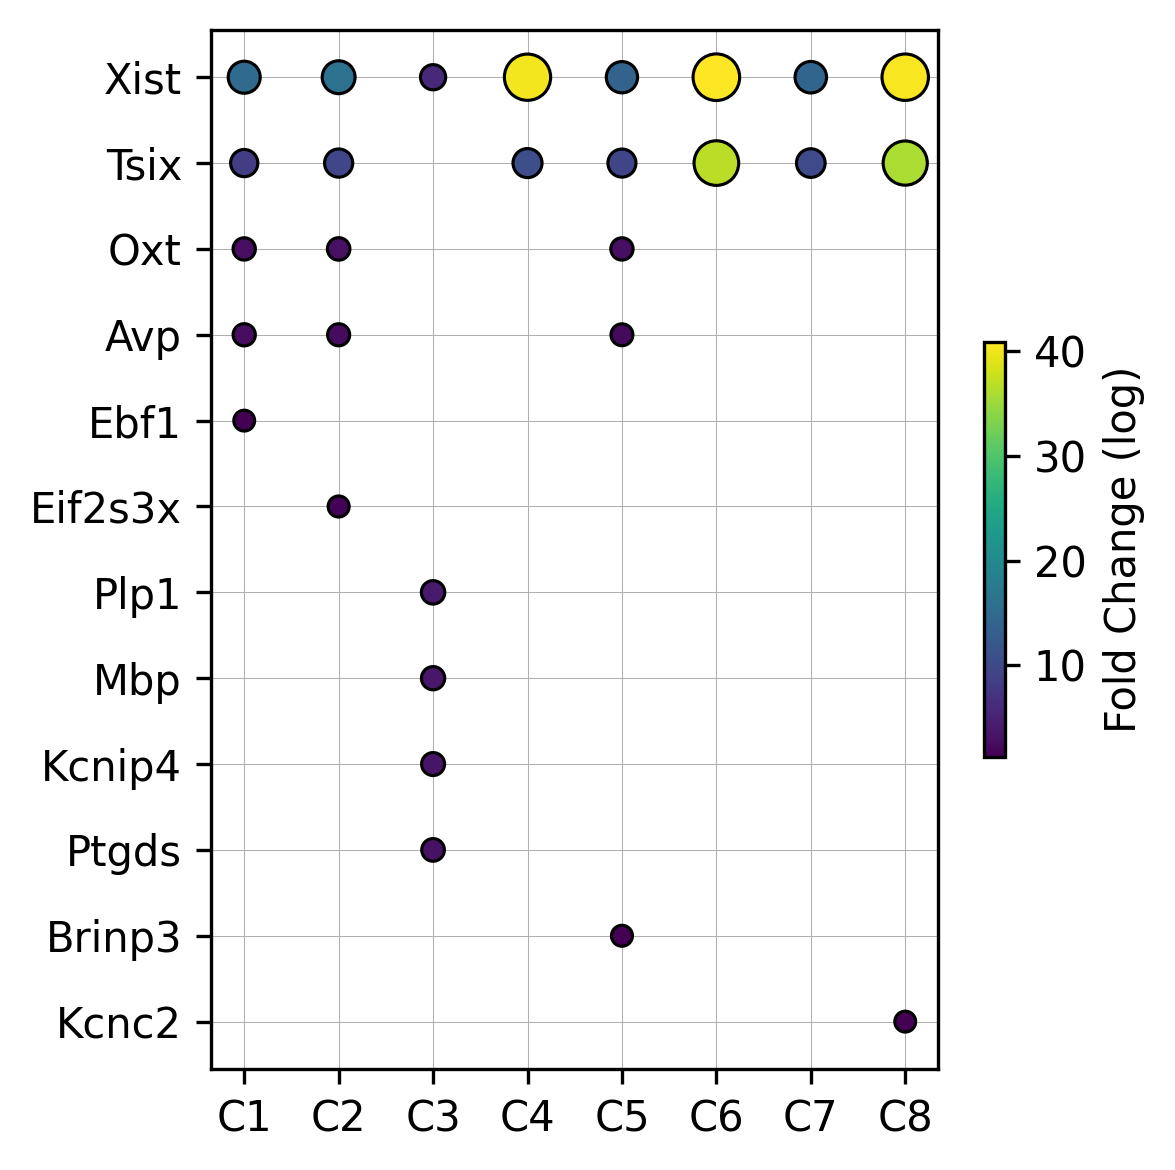

In [68]:
def plot_top_genes_scatter(deg, n, min_log_fold_change, 
                           max_log_fold_change, pval_threshold, 
                           selection='largest'):
    """
    Plots a scatterplot of the top n genes for each cluster with a colorbar.
    
    Args:
      deg (pandas.DataFrame): The DataFrame containing gene expression data.
      n (int): The number of top genes to plot for each cluster.
      min_log_fold_change (float): Minimum log fold change for a gene to be considered.
     max_log_fold_change (float): Maximum log fold change for a gene to be considered.
      pval_threshold (float): Significance threshold based on pvals_adj.
      selection (str): Whether to select the 'largest' or 'smallest' genes. 
                       Defaults to 'largest'. 
    """
    
    def filter_and_get_top_genes(df):
        """Filters data and extracts top genes within each group."""
        if selection == 'largest':
            return df[
            (df['logfoldchanges'] >= min_log_fold_change) &
            (df['logfoldchanges'] <= max_log_fold_change) &
            (df['pvals_adj'] <= pval_threshold) &
            (~df['names'].str.startswith("Gm")) &
            (~df['names'].str.startswith("mt")) &
            (~df['names'].str.endswith("Rik"))
            ].nlargest(n, 'logfoldchanges') 
        elif selection == 'smallest':
            return df[
             (df['logfoldchanges'] >= min_log_fold_change) &
             (df['logfoldchanges'] <= max_log_fold_change) &
             (df['pvals_adj'] <= pval_threshold) &
             (~df['names'].str.startswith("Gm")) &
             (~df['names'].str.startswith("mt")) &
             (~df['names'].str.endswith("Rik"))
            ].nsmallest(n, 'logfoldchanges') 
        else:
            raise ValueError("Invalid value for 'selection'. Choose either 'largest' or 'smallest'") 

    top_genes = deg.groupby('cluster').apply(filter_and_get_top_genes).reset_index(drop=True)
    top_genes[r'$-log_{10}$p-value'] = top_genes['pvals_adj'].apply(lambda x: -np.log10(x))
    top_genes['Fold Change (log)'] = top_genes['logfoldchanges']
    print(top_genes.columns)
    print(top_genes.head())

    # Scatterplot with Seaborn
    sns.scatterplot(data=top_genes, 
                    x='cluster',
                    y='names', 
                    hue='Fold Change (log)',
                    size='Fold Change (log)',
                    ec='k',
                    linewidths=0.75,
                    sizes=(25, 125),
                    palette='viridis',
                    legend=False,
                    zorder=4,
                   ) 
   
    # Normalize the color mappings
    norm = plt.Normalize(top_genes['Fold Change (log)'].min(), 
                         top_genes['Fold Change (log)'].max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  
    
    # Add the colorbar
    plt.colorbar(sm, label='Fold Change (log)', shrink=0.4,)

    # # Formatting
    plt.xlabel("") 
    plt.ylabel("") 
    plt.tight_layout()
    plt.grid(zorder=0, lw=0.25)
    plt.show()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

plot_top_genes_scatter(res, n=5,
                       min_log_fold_change=1.0, 
                       max_log_fold_change=1000,
                       pval_threshold=0.05)

Index(['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj', 'cluster',
       '$-log_{10}$p-value', 'Fold Change (log)'],
      dtype='object')
     names     scores  logfoldchanges  pvals  pvals_adj cluster  \
0  Eif2s3y -78.390121      -12.903085    0.0        0.0      C1   
1      Uty -67.399529      -12.004617    0.0        0.0      C1   
2    Kdm5d -49.936916      -11.613593    0.0        0.0      C1   
3    Ddx3y -45.360817       -9.078656    0.0        0.0      C1   
4     Pomc -64.990440       -6.589659    0.0        0.0      C1   

   $-log_{10}$p-value  Fold Change (log)  
0                 inf         -12.903085  
1                 inf         -12.004617  
2                 inf         -11.613593  
3                 inf          -9.078656  
4                 inf          -6.589659  


/tmp/ipykernel_94537/581833774.py:67: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fold Change (log)', shrink=0.4,)


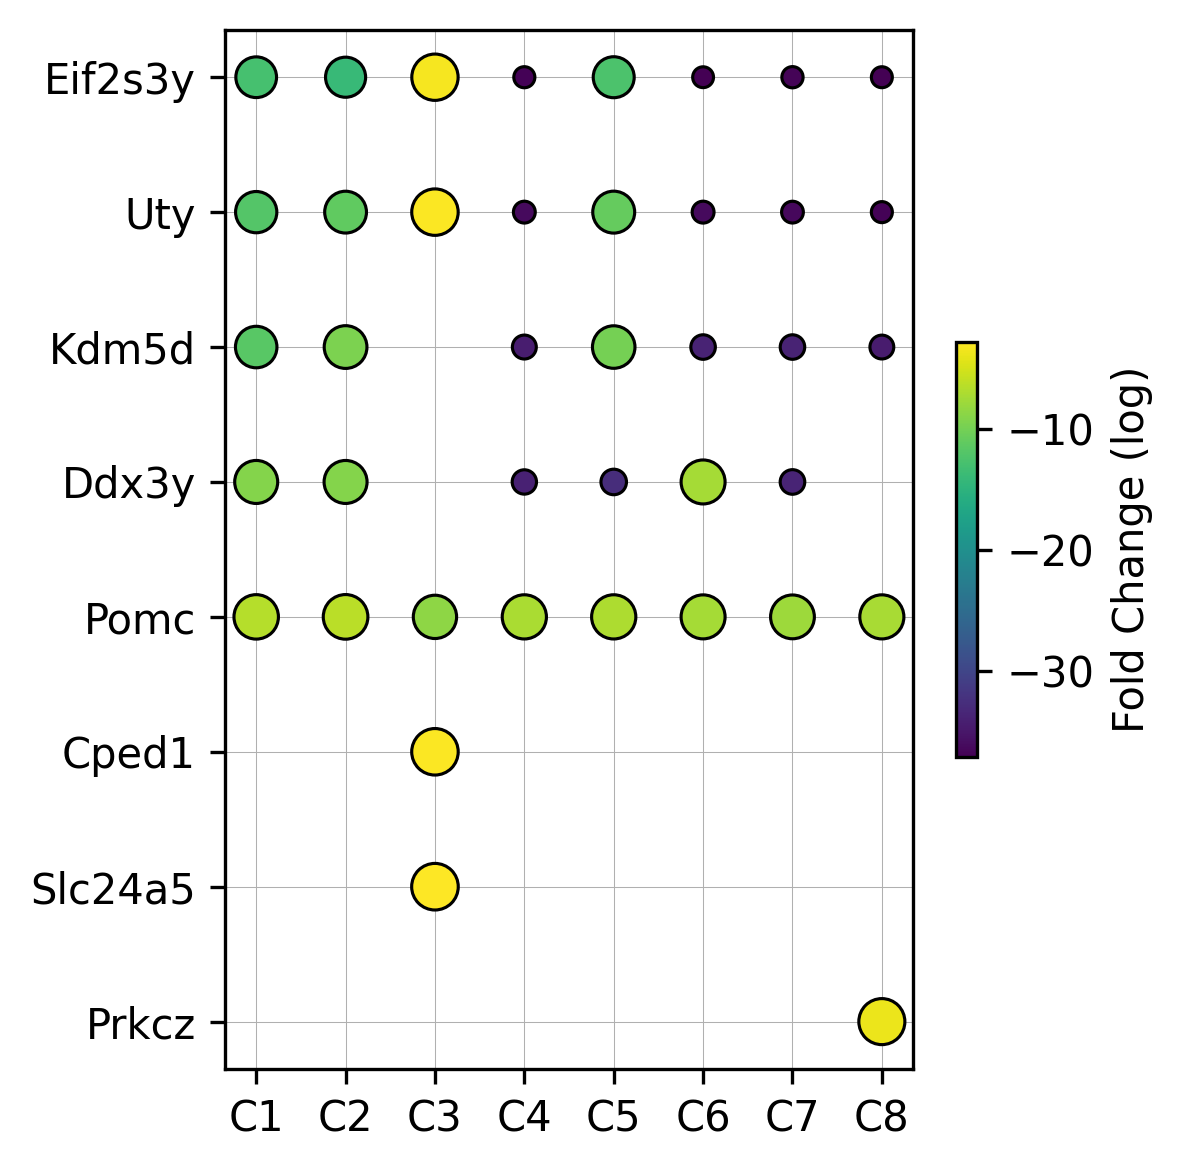

In [69]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

plot_top_genes_scatter(res, n=5,
                       min_log_fold_change=-1000, 
                       max_log_fold_change=-1.0, 
                       pval_threshold=0.05,
                       selection='smallest')

In [ ]:
break

In [ ]:
# def plot_top_genes_heatmap(deg, n, min_log_fold_change, pval_threshold):
#     """
#     Plots a heatmap of the top n genes for each cluster.

#     Args:
#         deg (pandas.DataFrame): The DataFrame containing gene expression data.
#         n (int): The number of top genes to plot for each cluster.
#         min_log_fold_change (float): Minimum log fold change for a gene to be considered.
#         pval_threshold (float): Significance threshold based on pvals_adj.
#     """

#     def filter_and_get_top_genes(df):
#         """Filters data and extracts top genes within each group."""
#         return df[(df['logfoldchanges'] >= min_log_fold_change) &
#                   (df['pvals_adj'] <= pval_threshold) &
#                   (~df['names'].str.startswith("Gm")) &
#                   (~df['names'].str.endswith("Rik"))
#                   ].nlargest(n, 'logfoldchanges') 

#     top_genes = deg.groupby('cluster').apply(filter_and_get_top_genes).reset_index(drop=True)

#     pivoted = top_genes.pivot(index='names', columns='cluster', values='logfoldchanges')

#     sns.heatmap(pivoted, cmap='coolwarm', 
#                 vmin=pivoted.min().min(), 
#                 vmax=pivoted.max().max(),
#                 lw=0.1,
#                 linecolor='k',
#                 cbar_kws={'shrink' : 0.5},
#                )

#     plt.xlabel("") 
#     plt.ylabel("") 
#     plt.show()

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 4, 7

# plot_top_genes_heatmap(res, n=5,
#                        min_log_fold_change=2.0, 
#                        pval_threshold=0.05)

In [ ]:
def plot_top_genes_scatter(deg, n, min_log_fold_change, pval_threshold):
    """
    Plots a scatterplot of the top n genes for each cluster.

    Args:
        deg (pandas.DataFrame): The DataFrame containing gene expression data.
        n (int): The number of top genes to plot for each cluster.
        min_log_fold_change (float): Minimum log fold change for a gene to be considered.
        pval_threshold (float): Significance threshold based on pvals_adj.
    """

    def filter_and_get_top_genes(df):
        """Filters data and extracts top genes within each group."""
        return df[(df['logfoldchanges'] >= min_log_fold_change) &
                  (df['pvals_adj'] <= pval_threshold) &
                  (~df['names'].str.startswith("Gm")) &
                  (~df['names'].str.endswith("Rik"))
                  ].nlargest(n, 'logfoldchanges') 


    top_genes = deg.groupby('cluster').apply(filter_and_get_top_genes).reset_index(drop=True)

    # Scatterplot with Seaborn
    sns.scatterplot(data=top_genes, 
                    x='cluster',
                    y='names', 
                    hue='logfoldchanges',
                    size='pvals_adj',) 

    # # Formatting
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')  # Move legend outside the plot
    plt.tight_layout()
    plt.show()

plot_top_genes_scatter(res, n=5,
                       min_log_fold_change=2.0, 
                       pval_threshold=0.05)

### 

In [ ]:
res.columns

In [ ]:
break